# A: Trend Calculation

## 1. Import modules

In [232]:
import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots
sns.set_theme('talk', style = 'white')

## 2. Loading and cleaning the dataset

In [233]:
# 2.1) Load dataset

data = pd.read_excel('pwt110_download_2025_11_24.xlsx', sheet_name='Data')
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(data.head())

Shape: (13690, 51)
Columns: ['countrycode', 'country', 'currency_unit', 'year', 'rgdpe', 'rgdpo', 'pop', 'emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck', 'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'pl_k']
  countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc  \
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN   
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   
2         ABW   Aruba  Aruban Guilder  1952    NaN    NaN  NaN  NaN  NaN NaN   
3         ABW   Aruba  Aruban Guilder  1953    NaN    NaN  NaN  NaN  NaN NaN   
4         ABW   Aruba  Aruban Guilder  1954    NaN    NaN  NaN  NaN  NaN NaN   

   ...  csh_x  csh_m  csh_r  pl_c  pl

In [234]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpe", "pop")]
data["rgdpe_pc"] = data["rgdpe"] / data["pop"]

# Select Sri Lanka 
data = data.loc[data["country"] == "Sri Lanka", ("year", "rgdpe", "rgdpe_pc")]

# Reset the index
data = data.reset_index(drop=True)

# Subset the RGDP per capita series
ymax = 2023
ymin = 1950

# For GDP per capita 
Y_pc = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe_pc"]
y_pc = np.log(Y_pc)

# For total GDP 
Y_gdp = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpe"]
y_gdp = np.log(Y_gdp)

# Filter data 
data = data[data["year"] >= ymin]  # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample

T = len(Y_pc)  # sample size used for regression
T_all = data["year"].max() - (ymin - 1)  # number of all years in the data after ymin

In [235]:
# Browse the cleaned data filtered for Sri Lanka (1950-2023)
data

,year,rgdpe,rgdpe_pc
0,1950,25357.488281,3456.990971
1,1951,27267.125000,3610.934647
2,1952,24134.570312,3102.942043
3,1953,25326.912109,3160.501812
4,1954,28594.119141,3467.465989
...,...,...,...
69,2019,322498.687500,14390.483889
70,2020,289517.468750,12832.193306
71,2021,309878.718750,13650.821174
72,2022,287845.812500,12605.485163


## 3. Compute different trend specifications

We want to compute four different specifications: (i) additive + linear (ii) additive + quadratic
(iii) exponential + linear and (iv) exponential + quadratic. This notebook only generates the results for the linear additive model, you will have to program the results for the other three cases yourself.

We will not do anything extraordinary, but simply run a linear regression. In Stata, you would run
`reg y x1 x2`. In R, you would run `lm(formula = y ~ x1 + x2, data)`. We will run
`get_regression_coefs(y, x1, x2)` in Python. The difference is that you can understand what's going on under the hood of your
program by looking at get_regression_coefs yourself

To see what `get_regression_coefs(y, x1, x2)` does in more details see the get_regression_coefs.py
file or simply type  'help(get_regression_coefs)` in a code window.

This program only generates the results for the linear additive model. You will have to program the results for the other three cases yourself.

In terms of presenting the results, it is important that you present them in a way such that the four different approaches are comparable and transparent. If not, then the discussion is unlikely to be convincing. 


Compute different trend specifications for: 
1. Additive Linear
2. Additive Quadratic
3. Exponential Linear
4. Exponential Quadratic

### 3.1 Additive Linear Model

In [236]:
# Compute the Additive Linear model for both Total GDP and GDP Per Capita

# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is GDP in *levels*


x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty(T)  # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1  # recall that Python starts indexing at 0

# For GDP total
a_add_lin_gdp, b_add_lin_gdp = get_regression_coefs(Y_gdp, x1, x2)

# For GDP per capita
a_add_lin_pc, b_add_lin_pc = get_regression_coefs(Y_pc, x1, x2)

Having computed the coefficients, we can now evaluate the trend for the entire time series, i.e.
also for years later than those used in the regression.

In [237]:
# Predictions for Total GDP
# Initialise predicted values Yhat
Yhat_add_lin_gdp = np.empty(T)  # Changed from T_all to T

# Create loop to compute trend for all years
for t in range(T):  # Changed from T_all to T
    Yhat_add_lin_gdp[t] = a_add_lin_gdp + b_add_lin_gdp * (t + 1)

# Let us convert into log-units
yhat_add_lin_gdp = np.log(Yhat_add_lin_gdp)


# Predictions for GDP per capita 
# Initialise predicted values Yhat
Yhat_add_lin_pc = np.empty(T)  # Changed from T_all to T

# Create loop to compute trend for all years
for t in range(T):  # Changed from T_all to T
    Yhat_add_lin_pc[t] = a_add_lin_pc + b_add_lin_pc * (t + 1)

# Convert into log-units
yhat_add_lin_pc = np.log(Yhat_add_lin_pc)

/var/folders/3l/x_n29jbd5dv5hq7x97zwtkw40000gn/T/ipykernel_3044/1741947535.py:10: RuntimeWarning: invalid value encountered in log
  yhat_add_lin_gdp = np.log(Yhat_add_lin_gdp)


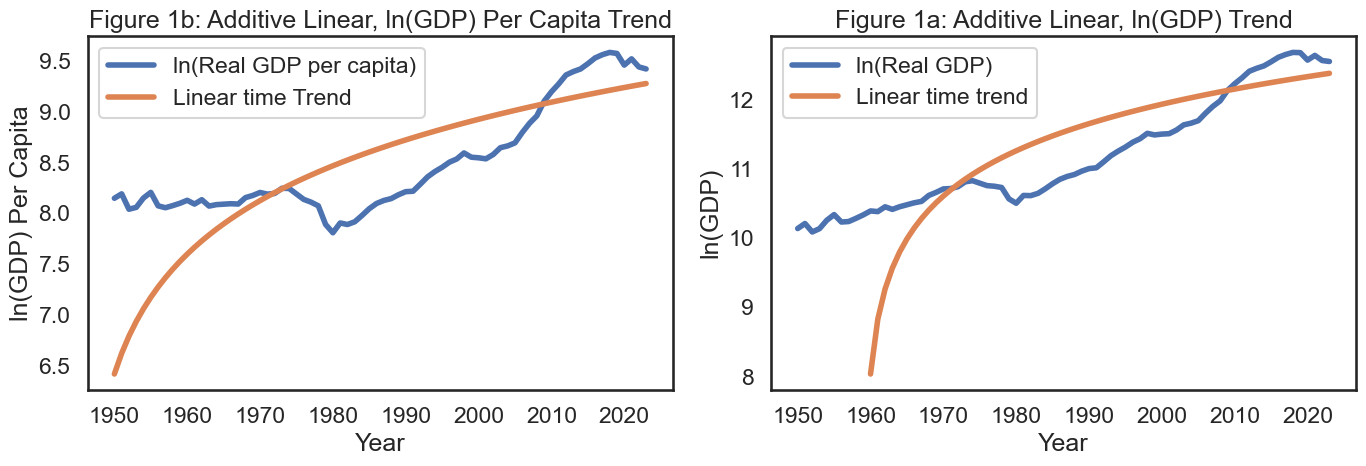

In [238]:
# Visualizations for Additive Linear

lw = 4  # Define linewidth
plt.figure(figsize=(14, 5))

# Panel 1b: GDP Per Capita
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, label='ln(Real GDP per capita)')
plt.plot(data['year'], yhat_add_lin_pc, linewidth=lw, label='Linear time Trend')
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 1b: Additive Linear, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

# Panel 1a: Total GDP
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, label='ln(Real GDP)')
plt.plot(data['year'], yhat_add_lin_gdp, linewidth=lw, label='Linear time trend')
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 1a: Additive Linear, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

plt.tight_layout()
plt.show()

NOTES TO DELETE AFTER --> Add labels

This plots the results of Model 3.1 (Linear Additive):

- Blue line: Actual log(GDP) data points
- Orange line: The fitted linear trend (yhat_add_lin)

### 3.2 Additive Quadratic Model

In [239]:
# 3.2) Additive Quadratic Model for Both total GDP and GDP Per Capita
# Other regressors: linear term (t) and quadratic term (t²)
# The dependent variable is GDP in *log levels*

x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty((T, 2))  # initialise a 2D array for linear and quadratic terms

for t in range(T):
    x1[t] = 1.
    x2[t, 0] = t + 1           # linear term
    x2[t, 1] = (t + 1)**2      # quadratic term

In [240]:
# For total GDP
a_add_quad_gdp, b_add_quad_lin_gdp, b_add_quad_sq_gdp = get_regression_coefs(y_gdp, x1, x2[:, 0], x2[:, 1])

# Initialise predicted values
yhat_add_quad_gdp = np.empty(T)

# Create loop to compute trend
for t in range(T):
    yhat_add_quad_gdp[t] = a_add_quad_gdp + b_add_quad_lin_gdp * (t + 1) + b_add_quad_sq_gdp * ((t + 1)**2)


# For GDP per capita 
a_add_quad_pc, b_add_quad_lin_pc, b_add_quad_sq_pc = get_regression_coefs(y_pc, x1, x2[:, 0], x2[:, 1])

# Initialise predicted values
yhat_add_quad_pc = np.empty(T)

# Create loop to compute trend
for t in range(T):
    yhat_add_quad_pc[t] = a_add_quad_pc + b_add_quad_lin_pc * (t + 1) + b_add_quad_sq_pc * ((t + 1)**2)

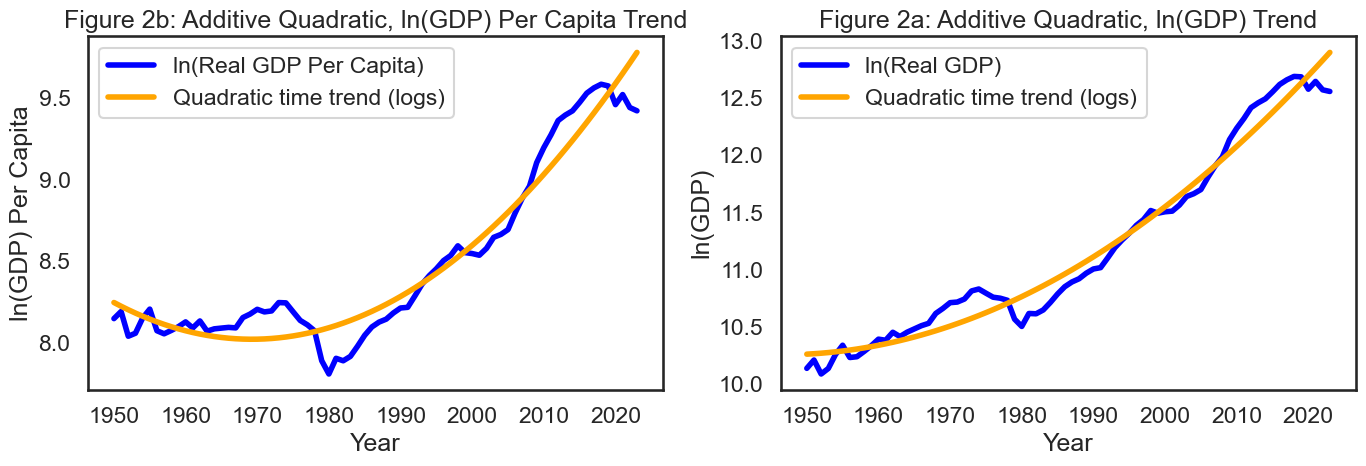

In [241]:
# Figure 2: Additive Quadratic - Two panels

plt.figure(figsize=(14, 5))

# Panel 2b: GDP Per Capita (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue', label='ln(Real GDP Per Capita)')
plt.plot(data['year'], yhat_add_quad_pc, linewidth=lw, color='orange', label='Quadratic time trend (logs)')
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 2b: Additive Quadratic, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

# Panel 2a: Total GDP (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue', label='ln(Real GDP)')
plt.plot(data['year'], yhat_add_quad_gdp, linewidth=lw, color='orange', label='Quadratic time trend (logs)')
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 2a: Additive Quadratic, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

plt.tight_layout()
plt.show()

In [242]:
print(f"Linear coefficient: {b_add_quad_lin_gdp}")
print(f"Quadratic coefficient: {b_add_quad_sq_gdp}")

Linear coefficient: 0.0023488384912740932
Quadratic coefficient: 0.0004494488555070858


NOTES: claude is telling me that the reason for U-shaped trend is due to: 

> The economic problem:
You're right - GDP shouldn't have a declining trend!
The quadratic is over-fitting to the dip around 1980 (Sri Lankan civil war period). It's treating that as part of the "trend" rather than a deviation.

> What this tells you:
This is actually a useful finding for your project:

> "The quadratic specification produces an economically implausible declining trend in early years, suggesting it over-fits to the 1980s conflict period rather than capturing true long-run growth."

DOUBLE CHECK THIS

### 3.3 Linear Exponential Model 

In [243]:
x1 = np.empty(T)
x2 = np.empty(T)  # 1D array, NOT (T, 2)!

for t in range(T):
    x1[t] = 1.
    scaled_t = (t + 1) / 100
    x2[t] = np.exp(scaled_t)  # Just one column

In [244]:
# For Total GDP
a_exp_lin_gdp, b_exp_lin_gdp = get_regression_coefs(Y_gdp, x1, x2)

Yhat_exp_lin_gdp = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_lin_gdp[t] = a_exp_lin_gdp + b_exp_lin_gdp * np.exp(scaled_t)

yhat_exp_lin_gdp = np.log(Yhat_exp_lin_gdp)

# For GDP per capita
a_exp_lin_pc, b_exp_lin_pc = get_regression_coefs(Y_pc, x1, x2)

Yhat_exp_lin_pc = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_lin_pc[t] = a_exp_lin_pc + b_exp_lin_pc * np.exp(scaled_t)

yhat_exp_lin_pc = np.log(Yhat_exp_lin_pc)

/var/folders/3l/x_n29jbd5dv5hq7x97zwtkw40000gn/T/ipykernel_3044/2880502580.py:9: RuntimeWarning: invalid value encountered in log
  yhat_exp_lin_gdp = np.log(Yhat_exp_lin_gdp)


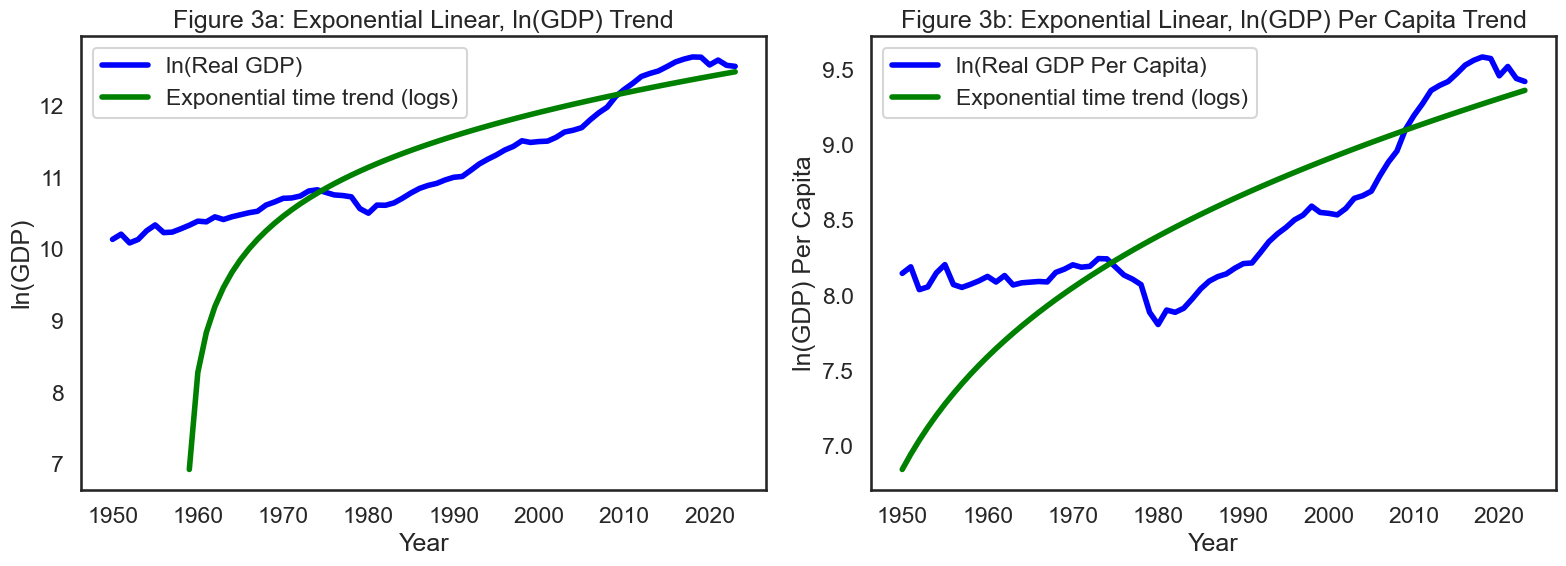

In [245]:
lw = 4

# Visualisations for Exponential linear

plt.figure(figsize=(16, 6))

# Panel 3a: Total GDP (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue', label='ln(Real GDP)')
plt.plot(data['year'], yhat_exp_lin_gdp, linewidth=lw, color='green', label='Exponential time trend (logs)')
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Figure 3a: Exponential Linear, ln(GDP) Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

# Panel 3b: GDP Per Capita (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue', label='ln(Real GDP Per Capita)')
plt.plot(data['year'], yhat_exp_lin_pc, linewidth=lw, color='green', label='Exponential time trend (logs)')
plt.xlabel("Year")
plt.ylabel("ln(GDP) Per Capita")
plt.title("Figure 3b: Exponential Linear, ln(GDP) Per Capita Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

plt.tight_layout()
plt.show()

### 3.4 Exponential Quadratic Model

In [246]:
# First regressor x1 is T x 1 vector of ones
# Other regressors: exp(t) and t·exp(t)
# The dependent variable is GDP in *levels* (not logged)

x1 = np.empty(T)  # initialise an empty vector for the first regressor
x2 = np.empty((T, 2))  # initialise a 2D array for exponential terms

for t in range(T):
    x1[t] = 1.
    scaled_t = (t + 1) / 100  # Scale down the time variable
    x2[t, 0] = np.exp(scaled_t)
    x2[t, 1] = scaled_t * np.exp(scaled_t)

In [247]:
# Total GDP
a_exp_quad_gdp, b_exp_quad_exp_gdp, b_exp_quad_texp_gdp = get_regression_coefs(Y_gdp, x1, x2[:, 0], x2[:, 1])

Yhat_exp_quad_gdp = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_quad_gdp[t] = a_exp_quad_gdp + b_exp_quad_exp_gdp * np.exp(scaled_t) + b_exp_quad_texp_gdp * scaled_t * np.exp(scaled_t)

# Convert to logs for plotting
yhat_exp_quad_gdp = np.log(Yhat_exp_quad_gdp)


# GDP per capita
a_exp_quad_pc, b_exp_quad_exp_pc, b_exp_quad_texp_pc = get_regression_coefs(Y_pc, x1, x2[:, 0], x2[:, 1])

Yhat_exp_quad_pc = np.empty(T)
for t in range(T):
    scaled_t = (t + 1) / 100
    Yhat_exp_quad_pc[t] = a_exp_quad_pc + b_exp_quad_exp_pc * np.exp(scaled_t) + b_exp_quad_texp_pc * scaled_t * np.exp(scaled_t)  # Use scaled_t!

# Convert to logs for plotting
yhat_exp_quad_pc = np.log(Yhat_exp_quad_pc)

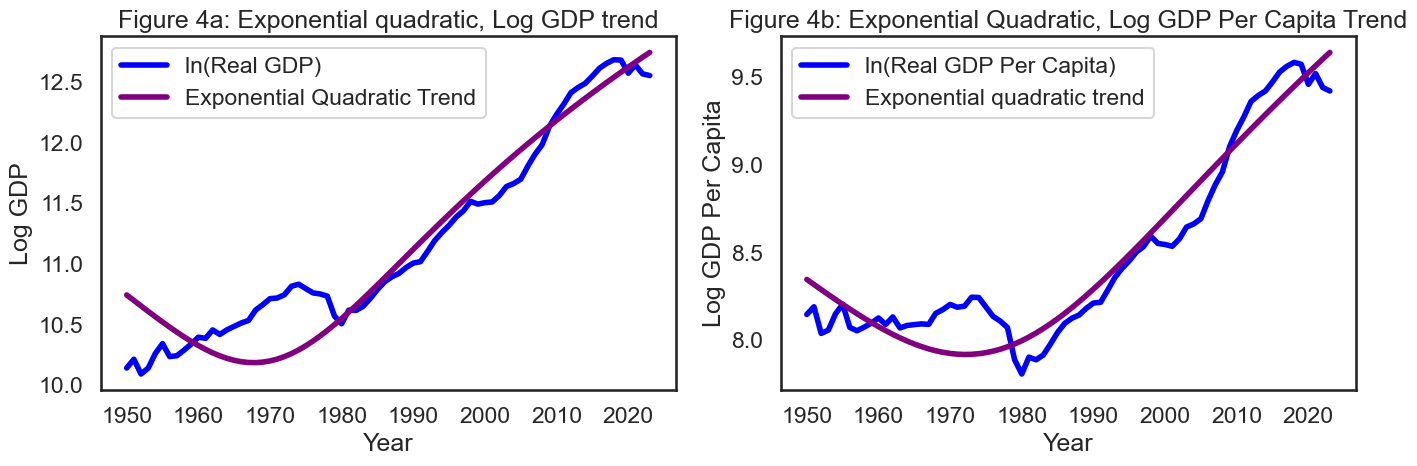

In [248]:
# Visualisations for Exponential Quadratic 

plt.figure(figsize=(14, 5))

# Panel 4a: Total GDP (LEFT)
plt.subplot(1, 2, 1)
plt.plot(data['year'], np.log(data['rgdpe']), linewidth=lw, color='blue', label='ln(Real GDP)')
plt.plot(data['year'], yhat_exp_quad_gdp, linewidth=lw, color='purple', label='Exponential Quadratic Trend')
plt.xlabel("Year")
plt.ylabel("Log GDP")
plt.title("Figure 4a: Exponential quadratic, Log GDP trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

# Panel 4b: GDP Per Capita (RIGHT)
plt.subplot(1, 2, 2)
plt.plot(data['year'], np.log(data['rgdpe_pc']), linewidth=lw, color='blue', label='ln(Real GDP Per Capita)')
plt.plot(data['year'], yhat_exp_quad_pc, linewidth=lw, color='purple', label='Exponential quadratic trend')
plt.xlabel("Year")
plt.ylabel("Log GDP Per Capita")
plt.title("Figure 4b: Exponential Quadratic, Log GDP Per Capita Trend")
plt.xticks(range(1950, 2030, 10))
plt.legend()

plt.tight_layout()
plt.show()

# B. Extract TFP Measure

**Production Function**

The Cobb-Douglas production function with human capital is:

$$
Y = K^{\alpha}(AhL)^{1-\alpha}, \quad 0 < \alpha < 1
$$

Where:
- $Y$: Real GDP (output)
- $K$: Capital stock
- $L$: Employment (number of workers)
- $h$: Human capital index
- $A$: Total Factor Productivity (TFP)
- $\alpha$: Capital share of output = **0.3**

**Solving for TFP**

Rearranging to solve for $A$:

$$
A = \frac{Y^{1/(1-\alpha)}}{K^{\alpha/(1-\alpha)} \cdot h \cdot L}
$$

Or equivalently in **log form**:

$$
\ln(A) = \frac{1}{1-\alpha}\ln(Y) - \frac{\alpha}{1-\alpha}\ln(K) - \ln(h) - \ln(L)
$$

With $\alpha = 0.3$:

$$
\ln(A) = \frac{1}{0.7}\ln(Y) - \frac{0.3}{0.7}\ln(K) - \ln(h) - \ln(L)
$$

$$
\ln(A) \approx 1.429\ln(Y) - 0.429\ln(K) - \ln(h) - \ln(L)
$$

**Data Variables**

From Penn World Table:
- **$Y$**: `rgdpna` (real GDP at constant 2017 national prices)
- **$K$**: `rnna` (capital stock at constant 2017 national prices)
- **$L$**: `emp` (number of employed workers)
- **$h$**: `hc` (human capital index)

In [249]:
# Load data again 
data_tfp = pd.read_excel('pwt110_download_2025_11_24.xlsx', sheet_name='Data')

# Subset relevant columns for TFP calculation
data_tfp = data_tfp.loc[:, ["country", "year", "rgdpna", "rnna", "emp", "hc"]]

# Filter to Sri Lanka
data_tfp = data_tfp.loc[data_tfp["country"] == "Sri Lanka", ["year", "rgdpna", "rnna", "emp", "hc"]]

# Reset index
data_tfp = data_tfp.reset_index(drop=True)

# Filter years
ymin = 1950
ymax = 2023
data_tfp = data_tfp[(data_tfp["year"] >= ymin) & (data_tfp["year"] <= ymax)]

In [250]:
# Set parameter
alpha = 0.3  # Capital share 

# Rename columns for clarity
data_tfp = data_tfp.rename(columns={
    'rgdpna': 'Y',
    'rnna': 'K',
    'emp': 'L',
    'hc': 'h'
})

# Extract variables from your data
Y = data_tfp["Y"].values  # Aggregate real GDP
K = data_tfp["K"].values  # Aggregate capital stock
L = data_tfp["L"].values  # Total employment
h = data_tfp["h"].values  # Human capital per worker

# Compute TFP with human capital (aggregate levels)
# Production function: Y = A · K^α · (h·L)^(1-α)
# Solving for A: A = Y / (K^α · (h·L)^(1-α))
A = Y / (K**alpha * (h * L)**(1 - alpha))

# Add TFP to dataframe
data_tfp['TFP'] = A

# Compute log TFP for easier interpretation
data_tfp['ln_TFP'] = np.log(A)

# Display first few rows with all columns
print("First 5 rows:")
data_tfp.head()

First 5 rows:


,year,Y,K,L,h,TFP,ln_TFP
0,1950,13178.016602,22397.904297,2.499192,1.483648,260.853339,5.563958
1,1951,14071.486328,23717.240234,2.555272,1.493016,268.392063,5.592449
2,1952,14925.839844,25058.650391,2.613895,1.502442,274.404615,5.614604
3,1953,14264.401367,25995.390625,2.674440,1.511928,254.126489,5.537832
4,1954,15341.320312,27000.187500,2.732963,1.521474,264.986663,5.579679


In [251]:
# Test robustness to different alpha values using LOGS
alphas = [0.25, 0.3, 0.35, 0.4]

for a in alphas:
    ln_tfp_col = f'ln_TFP_alpha_{a}'
    A = Y / (K**a * (h * L)**(1 - a))
    data_tfp[ln_tfp_col] = np.log(A)

# Display results in logs
print("Under different alpha values:")
data_tfp[['year', 'ln_TFP_alpha_0.25', 'ln_TFP_alpha_0.3', 'ln_TFP_alpha_0.35', 'ln_TFP_alpha_0.4']].head()

Under different alpha values:


,year,ln_TFP_alpha_0.25,ln_TFP_alpha_0.3,ln_TFP_alpha_0.35,ln_TFP_alpha_0.4
0,1950,5.999271,5.563958,5.128646,4.693333
1,1951,6.029199,5.592449,5.155699,4.718949
2,1952,6.052656,5.614604,5.176552,4.738500
3,1953,5.976260,5.537832,5.099405,4.660977
4,1954,6.018606,5.579679,5.140753,4.701826


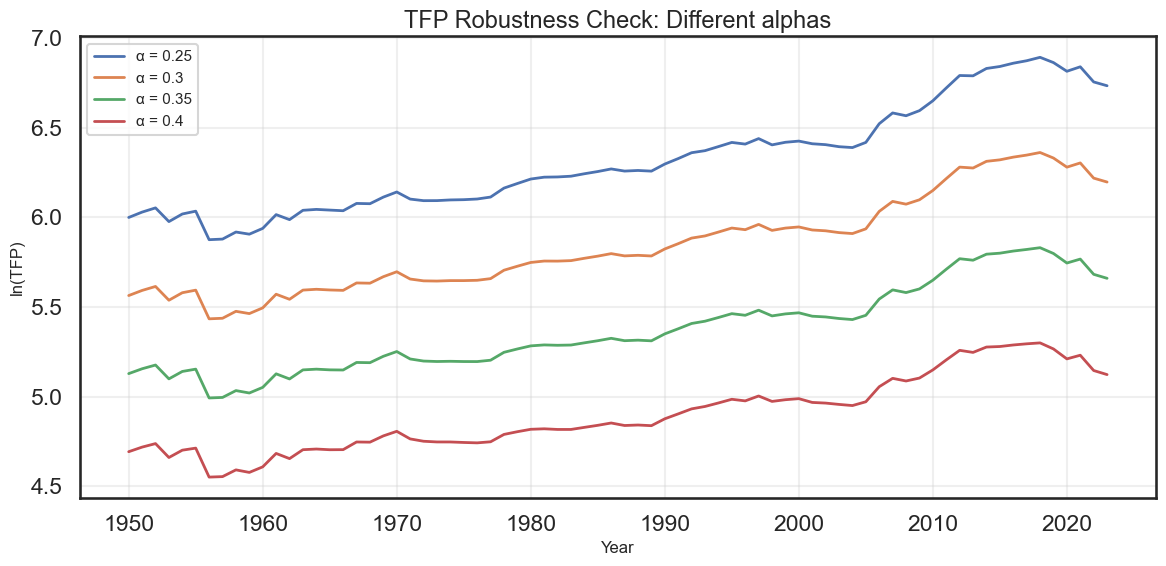

In [252]:
# Visualize TFP robustness

plt.figure(figsize=(12, 6))

for a in alphas:
    plt.plot(data_tfp['year'], data_tfp[f'ln_TFP_alpha_{a}'], 
             label=f'α = {a}', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('ln(TFP)', fontsize=12)
plt.title('TFP Robustness Check: Different alphas', fontsize=17)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [253]:
# We define a function that calculate yearly growth rates using log growth rates
def compute_growth_rate(X):
    # use of index slicing, e.g. X[1:] are all values starting from the second element, X[:-1] all elements up until (but not including) the last
    return np.log(X[1:] / X[:-1])  

# Extract GDP variable 
Y = data_tfp["Y"].values

# Calculate GDP growth rate
dY = compute_growth_rate(Y)

# Get years array
year = data_tfp['year'].values

# Display GDP growth rates
print("Year-by-year GDP growth rate for first five years:\n")
print("Year \t\t ln(Y_t/Y_{t-1})")

# Print first 5
for y1, y2, gy in zip(year[:5], year[1:6], dY[:5]):
    print(f"{y1:.0f}-{y2:.0f} \t\t {gy:.4f}")

Year-by-year GDP growth rate for first five years:

Year 		 ln(Y_t/Y_{t-1})
1950-1951 		 0.0656
1951-1952 		 0.0589
1952-1953 		 -0.0453
1953-1954 		 0.0728
1954-1955 		 0.0483


# C. Growth accounting

Average annual Y growth by period:
1950-1970: 0.0439
1970-1983: 0.0441
1983-2015: 0.0507
2015-2023: 0.0034


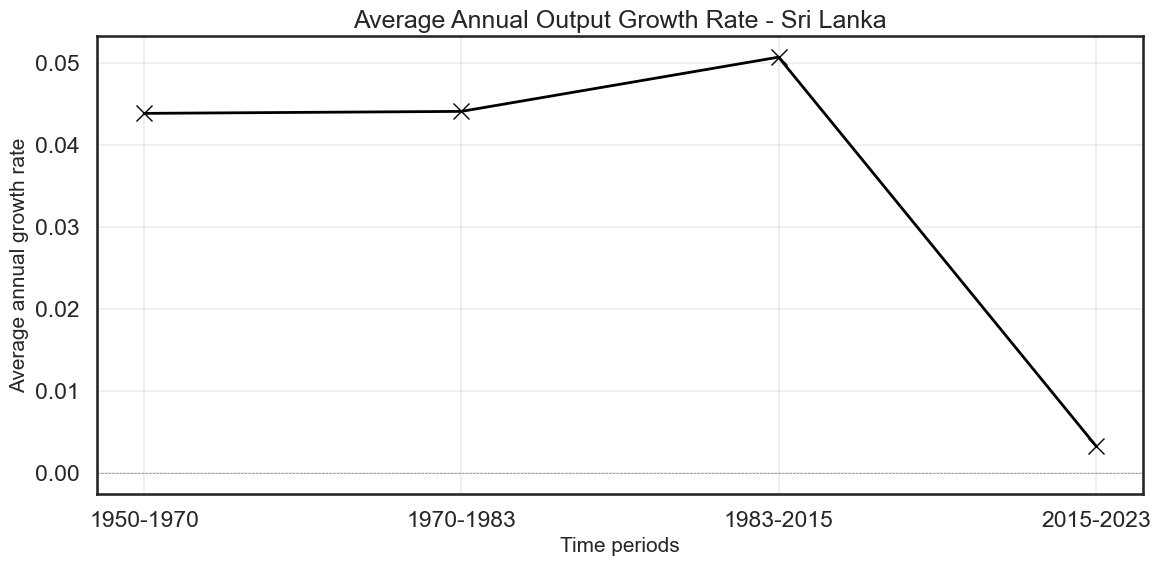

In [254]:
# Calculate average annual Y growth rates for sub-periods

# Define periods
periods = ['1950-1970', '1970-1983', '1983-2015', '2015-2023']
period_years = [(1950, 1970), (1970, 1983), (1983, 2015), (2015, 2023)]

# Calculate Y growth for each period
annualized_Y = []

for (start_year, end_year) in period_years:
    # Get data for start and end years
    start_data = data_tfp[data_tfp['year'] == start_year].iloc[0]
    end_data = data_tfp[data_tfp['year'] == end_year].iloc[0]
    
    # Number of years
    n = end_year - start_year
    
    # Calculate average annual Y growth
    y_growth = (1/n) * np.log(end_data['Y'] / start_data['Y'])
    
    annualized_Y.append(y_growth)

print("Average annual Y growth by period:")
for period, growth in zip(periods, annualized_Y):
    print(f"{period}: {growth:.4f}")

# Plot average annual Y growth by period

plt.figure(figsize=(12, 6))
x_pos = np.arange(len(periods))

plt.plot(x_pos, annualized_Y, marker='x', markersize=12, linewidth=2, color='black')

plt.xlabel('Time periods', fontsize=15)
plt.ylabel('Average annual growth rate', fontsize=15)
plt.title('Average Annual Output Growth Rate - Sri Lanka', fontsize=18)
plt.xticks(x_pos, periods)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## 1. Without human capital decompisition

We compute the contribution of each factor to the total growth rate of output (traditional Solow model, without hc decomposition).

$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot g_K \\
\text{contr\_L} &= (1 - \alpha) \cdot g_{L} \\
\text{contr\_A} &= g_A
\end{aligned}
$$

Where $g_Y = \text{contr\_K} + \text{contr\_L} + \text{contr\_A}$

Rationale for the sub-periods for Sri Lanka
1. 1950-2023 (entire period)
2. 1950-1970 (post-independence)
3. 1970-1983 (pre-civil war)
4. 1983-2015 (civil war and post-war recovery)
5. 2015-2023 (recent economic crisis)

In [255]:
# Calculate TFP without human capital

alpha = 0.3

# Extract variables 
Y = data_tfp["Y"].values
K = data_tfp["K"].values
L = data_tfp["L"].values

# Calculate TFP WITHOUT human capital: A = Y / (K^α · L^(1-α))
A_no_hc = Y / (K**alpha * L**(1 - alpha))
data_tfp['TFP_no_hc'] = A_no_hc
data_tfp['ln_TFP_no_hc'] = np.log(A_no_hc)

print(data_tfp[['year', 'TFP', 'TFP_no_hc']].head())

# Growth accounting

# Initialise dataframe
avg_growth_rates_no_hc = pd.DataFrame(
    data = np.full((5, 4), np.nan),
    columns = ['Y growth', 'K growth', 'L growth', 'A growth']
)

avg_growth_rates_no_hc['year'] = ["1950-2023", "1950-1970", "1970-1983", "1983-2015", "2015-2023"]
avg_growth_rates_no_hc = avg_growth_rates_no_hc.set_index('year')

# Get indices
idx_1950 = data_tfp[data_tfp['year'] == 1950].index[0]
idx_1970 = data_tfp[data_tfp['year'] == 1970].index[0]
idx_1983 = data_tfp[data_tfp['year'] == 1983].index[0]
idx_2015 = data_tfp[data_tfp['year'] == 2015].index[0]
idx_2023 = data_tfp[data_tfp['year'] == 2023].index[0]

# Calculate growth rates for each period
periods_data = [
    ('1950-2023', idx_1950, idx_2023),
    ('1950-1970', idx_1950, idx_1970),
    ('1970-1983', idx_1970, idx_1983),
    ('1983-2015', idx_1983, idx_2015),
    ('2015-2023', idx_2015, idx_2023)
]

for period, idx_start, idx_end in periods_data:
    avg_growth_rates_no_hc.loc[period, 'Y growth'] = np.log(data_tfp.loc[idx_end, 'Y'] / data_tfp.loc[idx_start, 'Y'])
    avg_growth_rates_no_hc.loc[period, 'K growth'] = np.log(data_tfp.loc[idx_end, 'K'] / data_tfp.loc[idx_start, 'K'])
    avg_growth_rates_no_hc.loc[period, 'L growth'] = np.log(data_tfp.loc[idx_end, 'L'] / data_tfp.loc[idx_start, 'L'])
    avg_growth_rates_no_hc.loc[period, 'A growth'] = np.log(data_tfp.loc[idx_end, 'TFP_no_hc'] / data_tfp.loc[idx_start, 'TFP_no_hc'])

# Compute contributions
df_contribs_no_hc = avg_growth_rates_no_hc.copy()
df_contribs_no_hc['K contribution'] = alpha * (df_contribs_no_hc['K growth'] / df_contribs_no_hc['Y growth'])
df_contribs_no_hc['L contribution'] = (1 - alpha) * (df_contribs_no_hc['L growth'] / df_contribs_no_hc['Y growth'])
df_contribs_no_hc['A contribution'] = df_contribs_no_hc['A growth'] / df_contribs_no_hc['Y growth']

# Keep selected columns
df_contribs_no_hc = df_contribs_no_hc[['Y growth', 'K contribution', 'L contribution', 'A contribution']]

# Display
print("\n" + "=" * 80)
print("Growth Accounting WITHOUT Human Capital (Traditional Solow)")
print("=" * 80)
df_contribs_no_hc

# Verify
df_contribs_no_hc['Total'] = df_contribs_no_hc['K contribution'] + df_contribs_no_hc['L contribution'] + df_contribs_no_hc['A contribution']
print("\nVerification (should sum to 1):")
df_contribs_no_hc[['K contribution', 'L contribution', 'A contribution', 'Total']]

   year         TFP   TFP_no_hc
0  1950  260.853339  343.817596
1  1951  268.392063  355.315964
2  1952  274.404615  364.879793
3  1953  254.126489  339.407693
4  1954  264.986663  355.475047

Growth Accounting WITHOUT Human Capital (Traditional Solow)

Verification (should sum to 1):


,K contribution,L contribution,A contribution,Total
year,,,,
1950-2023,0.376234,0.266047,0.357718,1.0
1950-1970,0.299999,0.329009,0.370992,1.0
1970-1983,0.456832,0.276746,0.266422,1.0
1983-2015,0.324915,0.216998,0.458087,1.0
2015-2023,4.248318,0.945251,-4.193569,1.0


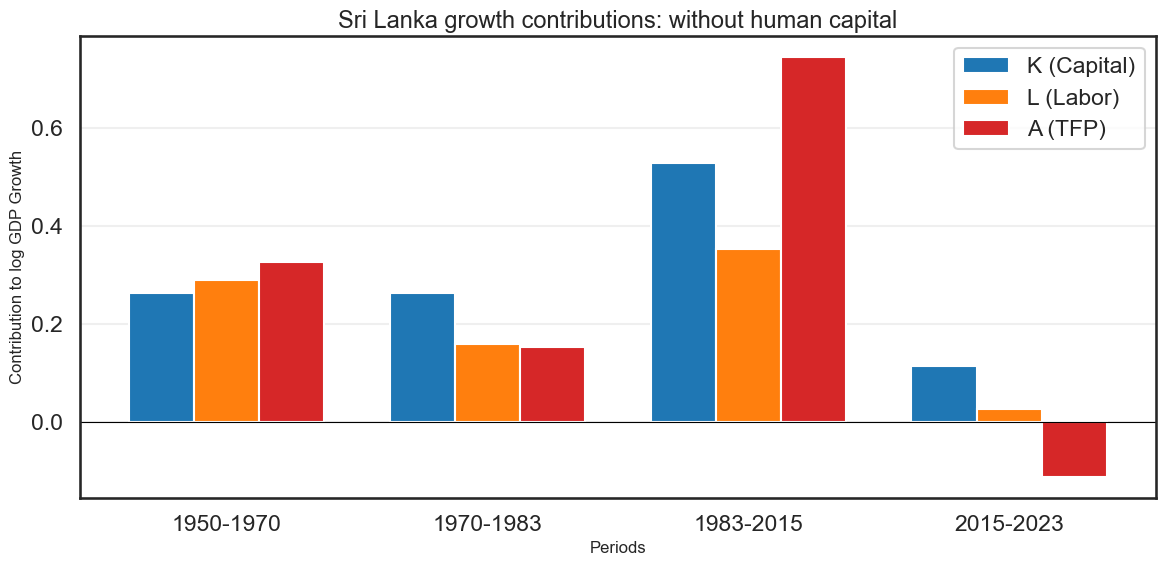

In [256]:
# Calculate contributions
K_contrib = [alpha * avg_growth_rates_no_hc.loc[p, 'K growth'] for p in periods]
L_contrib = [(1 - alpha) * avg_growth_rates_no_hc.loc[p, 'L growth'] for p in periods]
A_contrib = [avg_growth_rates_no_hc.loc[p, 'A growth'] for p in periods]

# Create the plot
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(periods))
width = 0.25

# Plot bars for each contribution (only 3 now: K, L, A)
plt.bar(x_pos - width, K_contrib, width, label='K (Capital)', color='#1f77b4')
plt.bar(x_pos, L_contrib, width, label='L (Labor)', color='#ff7f0e')
plt.bar(x_pos + width, A_contrib, width, label='A (TFP)', color='#d62728')

plt.xlabel('Periods', fontsize=12)
plt.ylabel('Contribution to log GDP Growth', fontsize=12)
plt.title('Sri Lanka growth contributions: without human capital', fontsize=17)
plt.xticks(x_pos, periods)
plt.legend(loc='upper right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2. With human capital decompisition

We next compute the contribution of each factor to the total growth rate of output with hc decomposition

$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot g_K \\
\text{contr\_HL} &= (1 - \alpha) \cdot g_{HL} \\
\text{contr\_A} &= g_A
\end{aligned}
$$

Where $g_Y = \text{contr\_K} + \text{contr\_HL} + \text{contr\_A}$

Rationale for the sub-periods for Sri Lanka
1. 1950-2023 (entire period)
2. 1950-1970 (post-independence)
3. 1970-1983 (pre-civil war)
4. 1983-2015 (civil war and post-war recovery)
5. 2015-2023 (recent economic crisis)

In [257]:
# Calculate TFP WITH human capital: A = Y / (K^α · (h·L)^(1-α))
A = Y / (K**alpha * (h * L)**(1 - alpha))
data_tfp['TFP'] = A
data_tfp['ln_TFP'] = np.log(A)

print(data_tfp[['year', 'TFP', 'h']].head())

# Growth accounting

# Initialise dataframe
avg_growth_rates = pd.DataFrame(
    data = np.full((5, 5), np.nan),
    columns = ['Y growth', 'K growth', 'L growth', 'h growth', 'A growth']
)

avg_growth_rates['year'] = ["1950-2023", "1950-1970", "1970-1983", "1983-2015", "2015-2023"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Get indices
idx_1950 = data_tfp[data_tfp['year'] == 1950].index[0]
idx_1970 = data_tfp[data_tfp['year'] == 1970].index[0]
idx_1983 = data_tfp[data_tfp['year'] == 1983].index[0]
idx_2015 = data_tfp[data_tfp['year'] == 2015].index[0]
idx_2023 = data_tfp[data_tfp['year'] == 2023].index[0]

# Calculate growth rates for each period
periods_data = [
    ('1950-2023', idx_1950, idx_2023),
    ('1950-1970', idx_1950, idx_1970),
    ('1970-1983', idx_1970, idx_1983),
    ('1983-2015', idx_1983, idx_2015),
    ('2015-2023', idx_2015, idx_2023)
]

for period, idx_start, idx_end in periods_data:
    avg_growth_rates.loc[period, 'Y growth'] = np.log(data_tfp.loc[idx_end, 'Y'] / data_tfp.loc[idx_start, 'Y'])
    avg_growth_rates.loc[period, 'K growth'] = np.log(data_tfp.loc[idx_end, 'K'] / data_tfp.loc[idx_start, 'K'])
    avg_growth_rates.loc[period, 'L growth'] = np.log(data_tfp.loc[idx_end, 'L'] / data_tfp.loc[idx_start, 'L'])
    avg_growth_rates.loc[period, 'h growth'] = np.log(data_tfp.loc[idx_end, 'h'] / data_tfp.loc[idx_start, 'h'])
    avg_growth_rates.loc[period, 'A growth'] = np.log(data_tfp.loc[idx_end, 'TFP'] / data_tfp.loc[idx_start, 'TFP'])

# Compute contributions
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = df_contribs_long['A growth'] / df_contribs_long['Y growth']

# Keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'L contribution', 'h contribution', 'A contribution']]

# Display
print("\n" + "=" * 80)
print("Growth Accounting WITH Human Capital (Augmented Solow)")
print("=" * 80)
df_contribs_long

# Verify
df_contribs_long['Total'] = (df_contribs_long['K contribution'] + 
                              df_contribs_long['L contribution'] + 
                              df_contribs_long['h contribution'] + 
                              df_contribs_long['A contribution'])
print("\nVerification (should sum to 1):")
df_contribs_long[['K contribution', 'L contribution', 'h contribution', 'A contribution', 'Total']]

   year         TFP         h
0  1950  260.853339  1.483648
1  1951  268.392063  1.493016
2  1952  274.404615  1.502442
3  1953  254.126489  1.511928
4  1954  264.986663  1.521474

Growth Accounting WITH Human Capital (Augmented Solow)

Verification (should sum to 1):


,K contribution,L contribution,h contribution,A contribution,Total
year,,,,,
1950-2023,0.376234,0.266047,0.153601,0.204117,1.0
1950-1970,0.299999,0.329009,0.219894,0.151098,1.0
1970-1983,0.456832,0.276746,0.158008,0.108414,1.0
1983-2015,0.324915,0.216998,0.111895,0.346192,1.0
2015-2023,4.248318,0.945251,0.414411,-4.607980,1.0


In [258]:
# Long-term Growth Accounting for Sri Lanka (1950-2023) 

# Initialize dataframe with NaNs (5 rows for 5 periods, 5 columns)
avg_growth_rates = pd.DataFrame(
    data = np.full((5, 5), np.nan),
    columns = ['Y growth', 'K growth', 'L growth', 'h growth', 'A growth']
)

# Define periods
avg_growth_rates['year'] = ["1950-2023", "1950-1970", "1970-1983", "1983-2015", "2015-2023"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Get indices for each year
idx_1950 = data_tfp[data_tfp['year'] == 1950].index[0]
idx_1970 = data_tfp[data_tfp['year'] == 1970].index[0]
idx_1983 = data_tfp[data_tfp['year'] == 1983].index[0]
idx_2015 = data_tfp[data_tfp['year'] == 2015].index[0]
idx_2023 = data_tfp[data_tfp['year'] == 2023].index[0]

# 1950-2023 (full period)
n_years = 2023 - 1950
avg_growth_rates.loc['1950-2023', 'Y growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'Y'] / data_tfp.loc[idx_1950, 'Y'])
avg_growth_rates.loc['1950-2023', 'K growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'K'] / data_tfp.loc[idx_1950, 'K'])
avg_growth_rates.loc['1950-2023', 'L growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'L'] / data_tfp.loc[idx_1950, 'L'])
avg_growth_rates.loc['1950-2023', 'h growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'h'] / data_tfp.loc[idx_1950, 'h'])
avg_growth_rates.loc['1950-2023', 'A growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'TFP'] / data_tfp.loc[idx_1950, 'TFP'])

# 1950-1970 sub-period
n_years = 1970 - 1950
avg_growth_rates.loc['1950-1970', 'Y growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1970, 'Y'] / data_tfp.loc[idx_1950, 'Y'])
avg_growth_rates.loc['1950-1970', 'K growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1970, 'K'] / data_tfp.loc[idx_1950, 'K'])
avg_growth_rates.loc['1950-1970', 'L growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1970, 'L'] / data_tfp.loc[idx_1950, 'L'])
avg_growth_rates.loc['1950-1970', 'h growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1970, 'h'] / data_tfp.loc[idx_1950, 'h'])
avg_growth_rates.loc['1950-1970', 'A growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1970, 'TFP'] / data_tfp.loc[idx_1950, 'TFP'])

# 1970-1983
n_years = 1983 - 1970
avg_growth_rates.loc['1970-1983', 'Y growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1983, 'Y'] / data_tfp.loc[idx_1970, 'Y'])
avg_growth_rates.loc['1970-1983', 'K growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1983, 'K'] / data_tfp.loc[idx_1970, 'K'])
avg_growth_rates.loc['1970-1983', 'L growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1983, 'L'] / data_tfp.loc[idx_1970, 'L'])
avg_growth_rates.loc['1970-1983', 'h growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1983, 'h'] / data_tfp.loc[idx_1970, 'h'])
avg_growth_rates.loc['1970-1983', 'A growth'] = (1/n_years) * np.log(data_tfp.loc[idx_1983, 'TFP'] / data_tfp.loc[idx_1970, 'TFP'])

# 1983-2015
n_years = 2015 - 1983
avg_growth_rates.loc['1983-2015', 'Y growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2015, 'Y'] / data_tfp.loc[idx_1983, 'Y'])
avg_growth_rates.loc['1983-2015', 'K growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2015, 'K'] / data_tfp.loc[idx_1983, 'K'])
avg_growth_rates.loc['1983-2015', 'L growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2015, 'L'] / data_tfp.loc[idx_1983, 'L'])
avg_growth_rates.loc['1983-2015', 'h growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2015, 'h'] / data_tfp.loc[idx_1983, 'h'])
avg_growth_rates.loc['1983-2015', 'A growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2015, 'TFP'] / data_tfp.loc[idx_1983, 'TFP'])

# 2015-2023
n_years = 2023 - 2015
avg_growth_rates.loc['2015-2023', 'Y growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'Y'] / data_tfp.loc[idx_2015, 'Y'])
avg_growth_rates.loc['2015-2023', 'K growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'K'] / data_tfp.loc[idx_2015, 'K'])
avg_growth_rates.loc['2015-2023', 'L growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'L'] / data_tfp.loc[idx_2015, 'L'])
avg_growth_rates.loc['2015-2023', 'h growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'h'] / data_tfp.loc[idx_2015, 'h'])
avg_growth_rates.loc['2015-2023', 'A growth'] = (1/n_years) * np.log(data_tfp.loc[idx_2023, 'TFP'] / data_tfp.loc[idx_2015, 'TFP'])

# Compute contribution rates (shares) 
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = df_contribs_long['A growth'] / df_contribs_long['Y growth']

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'L contribution', 'h contribution', 'A contribution']]

# Display results
print("Long-term growth accounting for Sri Lanka:") 
df_contribs_long


Long-term growth accounting for Sri Lanka:


,Y growth,K contribution,L contribution,h contribution,A contribution
year,,,,,
1950-2023,0.042472,0.376234,0.266047,0.153601,0.204117
1950-1970,0.043864,0.299999,0.329009,0.219894,0.151098
1970-1983,0.044106,0.456832,0.276746,0.158008,0.108414
1983-2015,0.050717,0.324915,0.216998,0.111895,0.346192
2015-2023,0.003356,4.248318,0.945251,0.414411,-4.607980


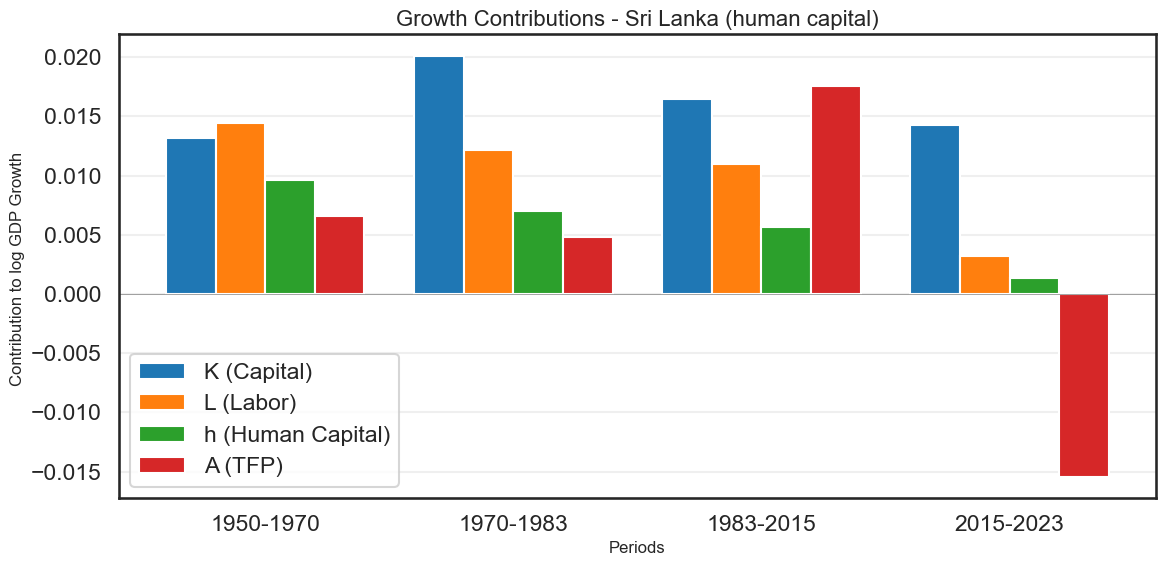

In [259]:
# Calculate shares of contributions
K_contrib = [alpha * avg_growth_rates.loc[p, 'K growth'] for p in periods]
L_contrib = [(1 - alpha) * avg_growth_rates.loc[p, 'L growth'] for p in periods]
h_contrib = [(1 - alpha) * avg_growth_rates.loc[p, 'h growth'] for p in periods]
A_contrib = [avg_growth_rates.loc[p, 'A growth'] for p in periods]

# Create the plot
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(periods))
width = 0.2

# Plot bars for each contribution
plt.bar(x_pos - 1.5*width, K_contrib, width, label='K (Capital)', color='#1f77b4')
plt.bar(x_pos - 0.5*width, L_contrib, width, label='L (Labor)', color='#ff7f0e')
plt.bar(x_pos + 0.5*width, h_contrib, width, label='h (Human Capital)', color='#2ca02c')
plt.bar(x_pos + 1.5*width, A_contrib, width, label='A (TFP)', color='#d62728')

plt.xlabel('Periods', fontsize=12)
plt.ylabel('Contribution to log GDP Growth ', fontsize=12)
plt.title('Growth Contributions - Sri Lanka (human capital)', fontsize=16)
plt.xticks(x_pos, periods)
plt.legend()
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# D. Labour productivity

In [260]:
# Calculate labour prod (Y/L) - both levels and logs
data_tfp['labour_prod'] = data_tfp['Y'] / data_tfp['L']
data_tfp['ln_labour_prod'] = np.log(data_tfp['labour_prod'])

# Create a dataframe for labour prod with components
df_labour_prod = data_tfp[['year', 'labour_prod', 'ln_labour_prod', 'h']].copy()

# Display the series
print("Labour productivity series (GDP per worker)")
print(df_labour_prod.head())

Labour productivity series (GDP per worker)
   year  labour_prod  ln_labour_prod         h
0  1950  5272.910847        8.570338  1.483648
1  1951  5506.844580        8.613747  1.493016
2  1952  5710.191707        8.650008  1.502442
3  1953  5333.603721        8.581782  1.511928
4  1954  5613.439520        8.632919  1.521474


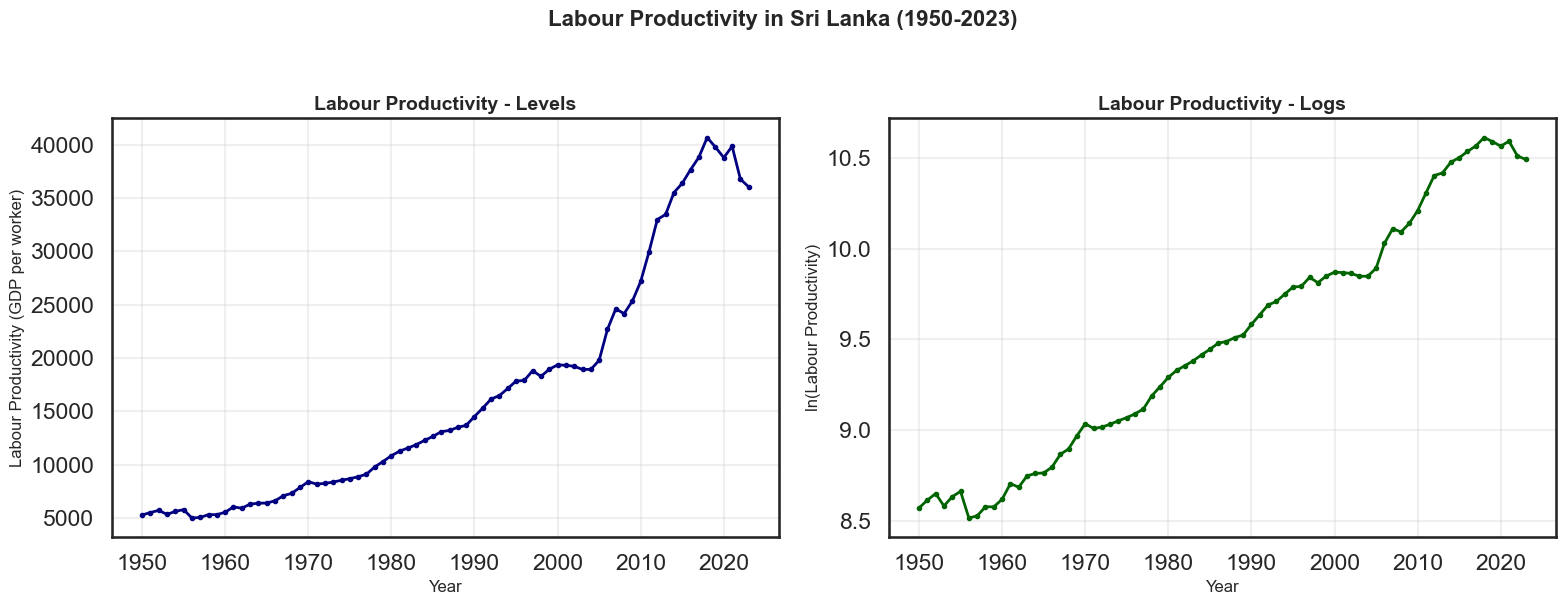

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Labour Productivity (Levels)
axes[0].plot(df_labour_prod['year'], df_labour_prod['labour_prod'], 
             linewidth=2, color='navy', marker='o', markersize=3)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Labour Productivity (GDP per worker)', fontsize=12)
axes[0].set_title('Labour Productivity - Levels', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Log Labour Productivity
axes[1].plot(df_labour_prod['year'], df_labour_prod['ln_labour_prod'], 
             linewidth=2, color='darkgreen', marker='o', markersize=3)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('ln(Labour Productivity)', fontsize=12)
axes[1].set_title('Labour Productivity - Logs', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Labour Productivity in Sri Lanka (1950-2023)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()